# Libraries

In [ ]:
# Python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Load Data set
The dataset is loaded and a min-max scaling is applied to the dataset

In [ ]:
mnist = tf.keras.datasets.mnist

# Load the full training & test data
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()


# Create validation dataset as well as scale (max-min scaling) the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)

No. of Training Samples:  (55000, 28, 28)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 28, 28)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 28, 28)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


# Experiment #1

**Summary:**
This notebook builds and trains a **multilayer perceptron (MLP)** model using TensorFlow and Keras to perform **multiclass classification** on 28×28 image data. The model architecture consists of an input layer that flattens the image pixels, followed by two fully connected hidden layers with **300 and 100 neurons** respectively, both using the **sigmoid activation** function and **zero weight initialization**. The final output layer uses a **softmax activation** to classify the data into **10 distinct classes**.

The training is carried out using the **stochastic gradient descent (SGD)** optimizer with a **learning rate of 0.1**, and the **Sparse Categorical Cross-Entropy** loss function suited for integer-encoded labels. To prevent overfitting and ensure efficient convergence, an **early stopping** callback is employed, which monitors validation loss and restores the best-performing model weights.

After training, the evaluates of the model’s performance on both the training and test datasets was done, displaying metrics such as **accuracy, confusion matrix, and classification report**. Finally, it visualizes the **training and validation accuracy and loss curves** across epochs to analyze the model’s learning behavior and generalization capability.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
860/860 [==============================] - 8s 9ms/step - loss: 2.3087 - accuracy: 0.1041 - val_loss: 2.3089 - val_accuracy: 0.0986
Epoch 2/50
860/860 [=====

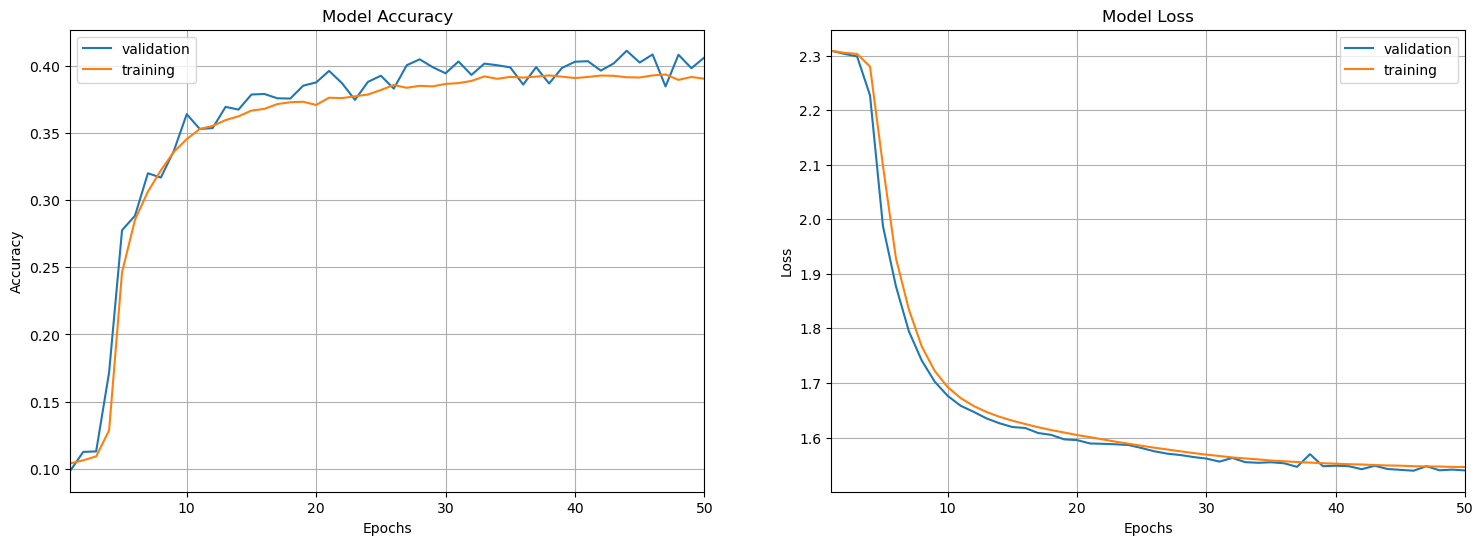

CPU times: user 1h 42min 46s, sys: 2h 40min 31s, total: 4h 23min 17s
Wall time: 16min 30s


In [ ]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise, memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration.
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'zeros'
activation_hidden = 'sigmoid'

# Final classification layer has 10 nerons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10

'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply or NOT Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
# No droput applied
#model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))

# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()


'''
Define the optimizer
An optimizer object implements an optimization algorithm used to minimize the loss function during model training.
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model

'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

## Experiment #2

**Summary**

This experiment trains a **multilayer perceptron (MLP)** to perform **10-class classification** on 28×28 images using TensorFlow/Keras. The model flattens each image, then passes it through two dense hidden layers (**300 → 100 neurons**) with **sigmoid** activations. A key design choice here is the **weight initializer set to `ones`** (with biases at zero), contrasting Experiment 1’s initializer—this lets us observe how a strongly biased starting point affects optimization and convergence. The final layer uses **softmax** to output class probabilities.

Training uses **SGD (lr = 0.1)** and **Sparse Categorical Cross-Entropy** for integer labels, with **early stopping** monitoring validation loss and restoring the best weights to curb overfitting.

The result shows **training/test accuracy**, prints **confusion matrix** and **classification report** to inspect class-wise behavior, and plots **accuracy and loss curves** for both training and validation across epochs. Together, these outputs tell a clear story about how the unusual **`ones` initialization** impacts learning dynamics, generalization, and class-level performance compared with more standard initializations.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 2.3824 - accuracy: 0.1001 - val_loss: 2.5614 - val_accuracy: 0.1002
Epoch 2/50
860/860 [=====

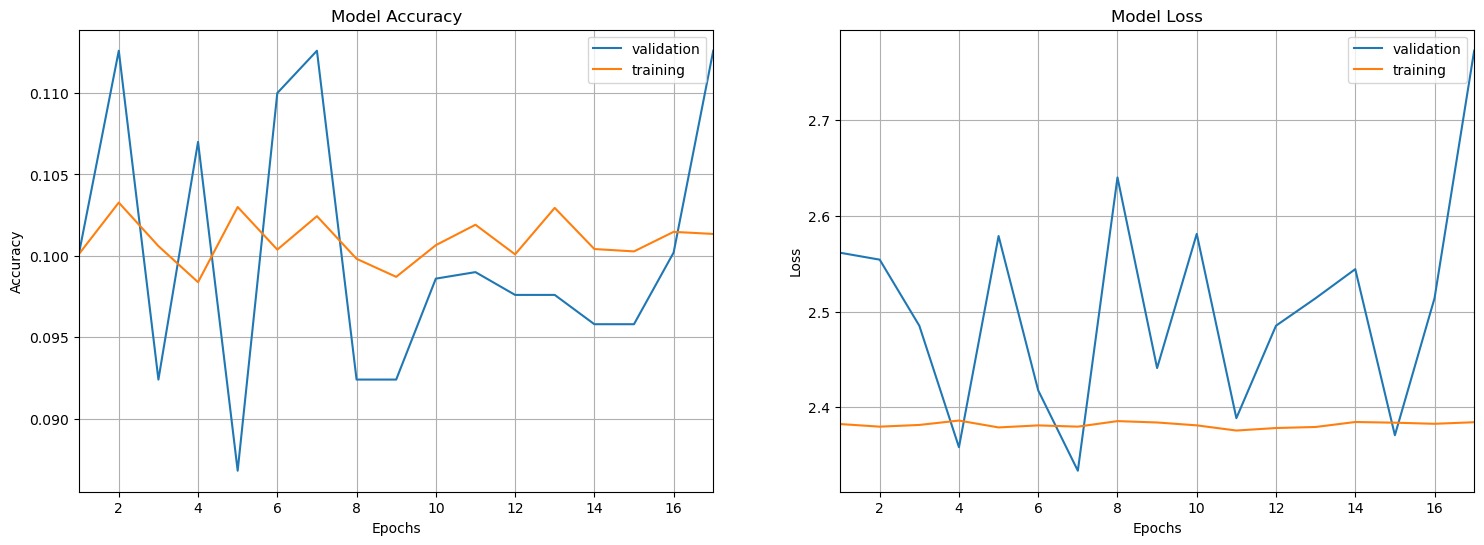

CPU times: user 3min 8s, sys: 6min 19s, total: 9min 28s
Wall time: 36.3 s


In [ ]:
%%time

'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'ones'
activation_hidden = 'sigmoid'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment # 3

**Summary**

In this experiment, we train a **multilayer perceptron (MLP)** to perform **10-class classification** on 28×28 images using TensorFlow/Keras. The pipeline resets the graph and seeds for reproducibility, then builds an architecture that **flattens the image** and feeds it through two dense hidden layers (**300 → 100 neurons**) with **sigmoid activations**. The key twist is the **`random_normal` weight initialization**, giving each run small, randomly drawn starting weights (with zero biases). This setup is designed to contrast with Experiments 1–2 (e.g., `zeros`, `ones`) and show how a more realistic stochastic starting point affects **optimization stability** and **convergence speed**.

We train with **SGD (learning rate = 0.1)** and **Sparse Categorical Cross-Entropy** for integer labels, while **early stopping** monitors validation loss and **restores the best weights** to prevent overfitting.


After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class). Finally, it plots **training vs. validation accuracy and loss** across epochs, enabling a quick read on learning dynamics and generalization—especially useful when comparing how **`random_normal` initialization** behaves relative to the deterministic initializations used earlier.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
860/860 [==============================] - 2s 2ms/step - loss: 1.7181 - accuracy: 0.4430 - val_loss: 0.8482 - val_accuracy: 0.7338
Epoch 2/50
860/860 [=====

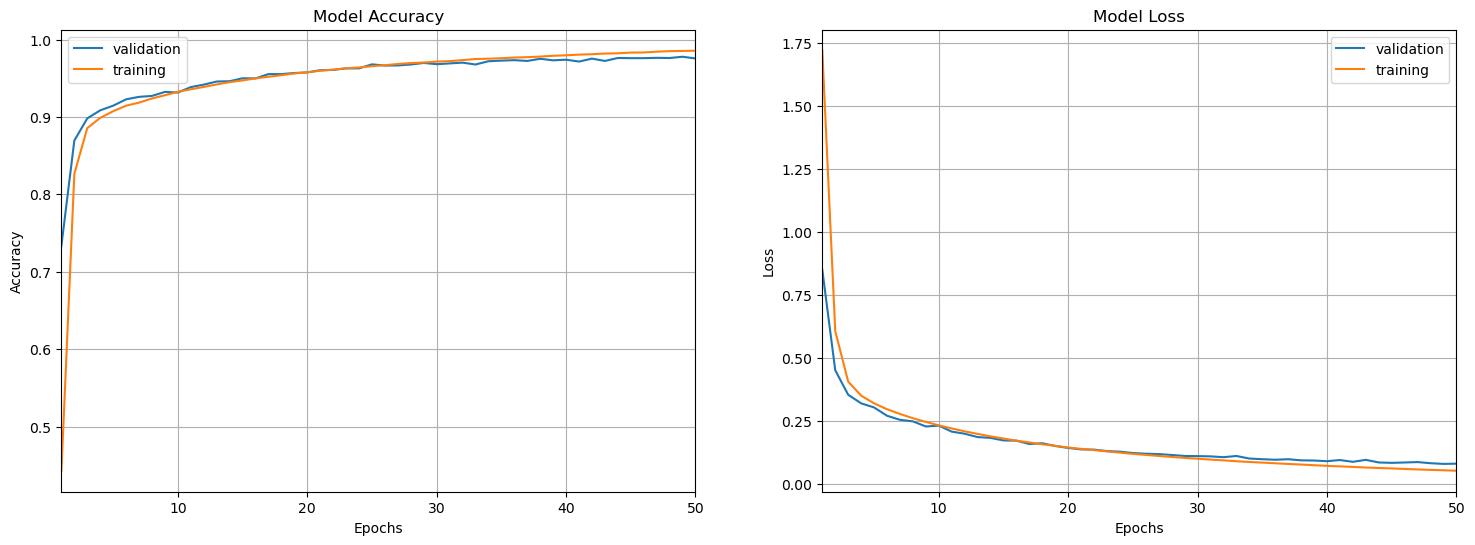

CPU times: user 29min 3s, sys: 49min 45s, total: 1h 18min 49s
Wall time: 4min 56s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'sigmoid'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment #4

**Summary**

This experiment implements and trains a **multilayer perceptron (MLP)** model to perform **10-class image classification** on 28×28 pixel data using TensorFlow/Keras. The architecture mirrors the previous experiments, flattening the image input and feeding it through two dense hidden layers (**300 to 100 neurons**) before outputting class probabilities through a **softmax** layer. However, this experiment introduces two critical changes: the hidden layers now use the **tanh activation function** and the **`random_normal` weight initializer**, enabling a comparison of how a different non-linear activation influences training dynamics and convergence behavior.

The model is optimized using **SGD (learning rate = 0.1)** and trained with **Sparse Categorical Cross-Entropy**, appropriate for integer-encoded labels. An **early stopping** callback monitors the validation loss, halting training if no improvement is seen and restoring the best weights to prevent overfitting.

After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class) for detailed performance analysis, and visualizes the **accuracy and loss curves** for training and validation across epochs.
Overall, this experiment examines how switching from **sigmoid to tanh activations** both smooth nonlinear functions affects the MLP’s learning efficiency, stability, and ability to generalize beyond the training data.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
860/860 [==============================] - 3s 3ms/step - loss: 0.4228 - accuracy: 0.8829 - val_loss: 0.2421 - val_accuracy: 0.9312
Epoch 2/50
860/860 [=====

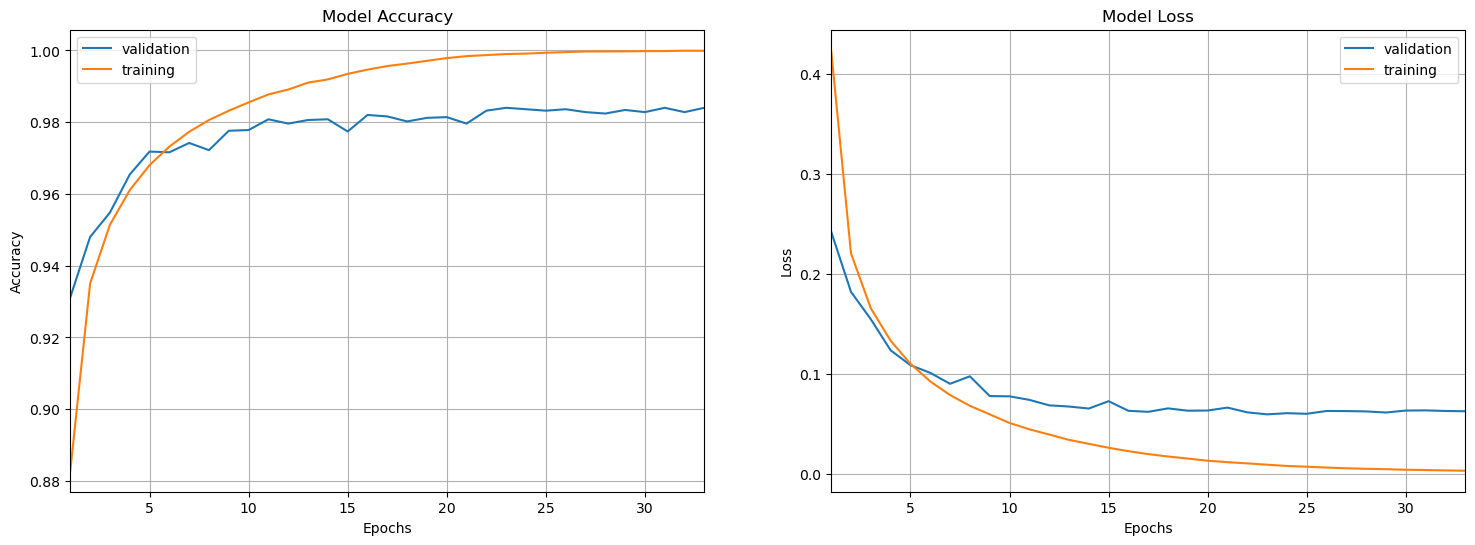

CPU times: user 7min, sys: 12min 30s, total: 19min 31s
Wall time: 1min 14s


In [ ]:
%%time

'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'tanh'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment # 5

**Summary**

In this experiment, a **multilayer perceptron (MLP)** model is trained to perform **10-class image classification** using TensorFlow/Keras. The model flattens 28×28 pixel input images and processes them through two dense hidden layers with **300 and 100 neurons**, respectively. This time, the experiment introduces the **ReLU (Rectified Linear Unit)** activation function while maintaining the **`random_normal` weight initializer**, allowing a direct comparison with previous experiments that used **sigmoid** and **tanh** activations. ReLU is known for mitigating vanishing gradient issues and promoting faster, more stable training.

The model uses **stochastic gradient descent (SGD)** with a **learning rate of 0.1** and the **Sparse Categorical Cross-Entropy** loss function. An **early stopping** mechanism monitors validation loss, stopping training when improvement stalls and restoring the best model weights to prevent overfitting.

After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class) to assess per-class performance, and visualizes **accuracy and loss curves** for both training and validation datasets.

Overall, this experiment explores how using **ReLU activation** enhances learning speed, convergence stability, and generalization compared to smoother nonlinearities like **sigmoid** and **tanh**, making it an important step toward optimizing neural network performance.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
860/860 [==============================] - 18s 20ms/step - loss: 0.4405 - accuracy: 0.8745 - val_loss: 0.1953 - val_accuracy: 0.9452
Epoch 2/50
860/860 [===

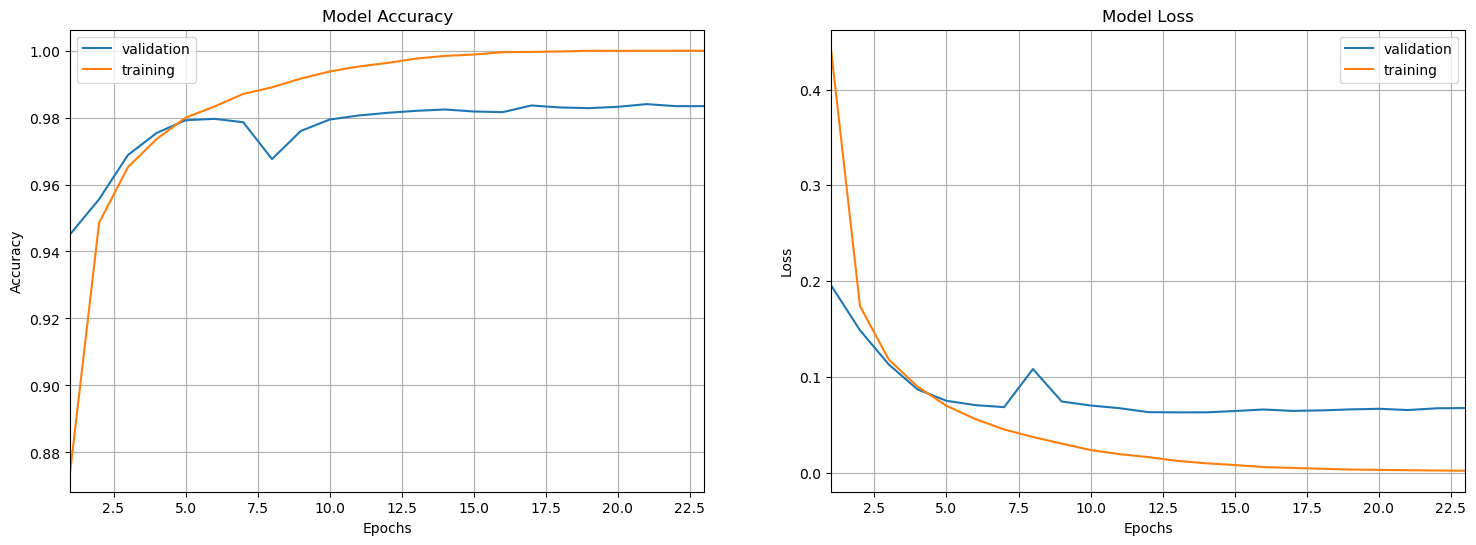

CPU times: user 20min 50s, sys: 23min 37s, total: 44min 27s
Wall time: 2min 47s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
#model.add(tf.keras.layers.Dropout(rate=0.1)) # add if needed
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment # 6

**Summary**

This experiment extends the previous multilayer perceptron (MLP) architecture for **10-class image classification** on 28×28 pixel data using TensorFlow/Keras, but introduces **Dropout regularization** to reduce overfitting and improve generalization. The model flattens the input image, then passes it through two fully connected hidden layers (**300 to 100 neurons**) with **ReLU activation** and **`random_normal` weight initialization**. After each hidden layer, a **Dropout layer with a 10% rate** randomly disables neurons during training, encouraging the model to learn more robust and distributed feature representations.

The model is trained using **stochastic gradient descent (SGD)** with a **learning rate of 0.1** and optimized via the **Sparse Categorical Cross-Entropy** loss function. **Early stopping** is implemented to monitor validation loss and restore the best-performing weights when further training no longer improves the model.

After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class), along with plots of **accuracy and loss curves** over epochs.

Overall, this experiment investigates how adding **Dropout** to a ReLU-activated MLP impacts learning stability and generalization compared to the non-regularized model in Experiment 5. It demonstrates the benefit of Dropout in preventing overfitting, especially in deep neural networks trained on image data.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 2

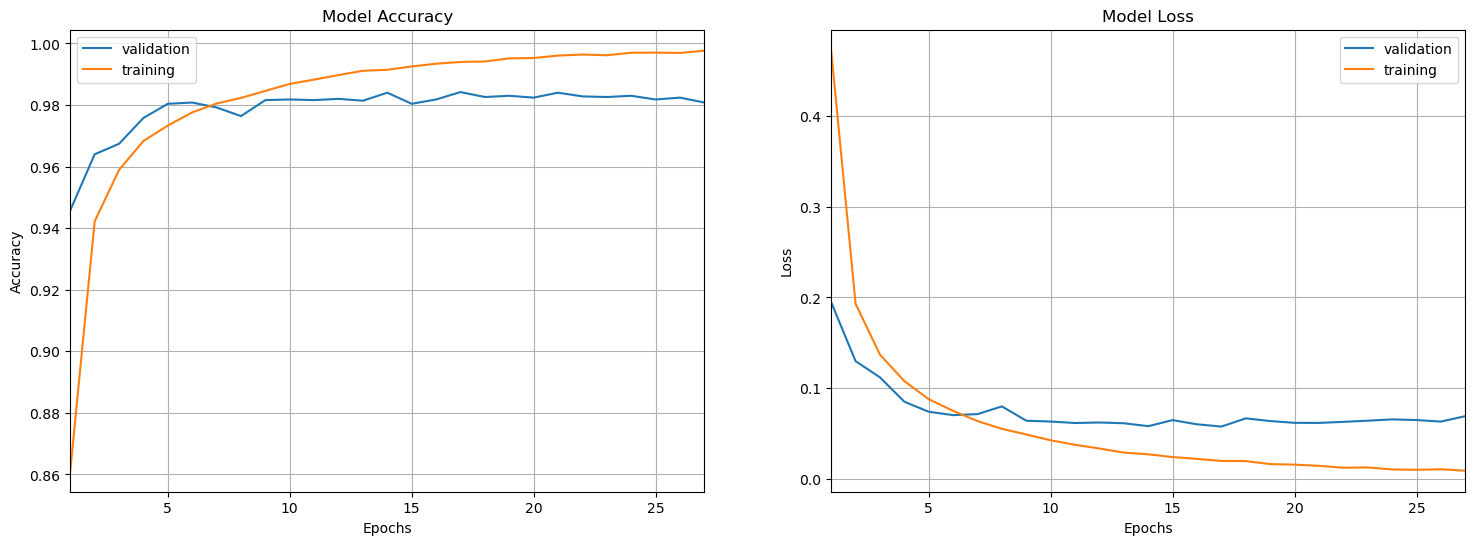

CPU times: user 40min 51s, sys: 1h 17min 32s, total: 1h 58min 23s
Wall time: 7min 26s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
# Dropout applied Hidden layer 1
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
# Dropout applied Hidden layer 2
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment #7

**Summary**

This experiment keeps the same **MLP for 10-class classification** on 28×28 images but tests a **stronger, asymmetric regularization scheme**. After flattening the input, the network uses two dense hidden layers (**300 to 100 neurons**) with **ReLU** activations and **`random_normal`** initialization. The twist is **Dropout at different rates per layer**:

* **50%** right after the first hidden layer (aggressive regularization to prevent early co-adaptation of features),
* **10%** after the second hidden layer (lighter regularization to preserve higher-level signals).

Training uses **SGD (lr = 0.1)** with **Sparse Categorical Cross-Entropy** and **early stopping** on validation loss (restoring the best weights). After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class), and plots **training vs. validation accuracy and loss** over epochs.

Overall, this run probes how **asymmetric dropout (0.5 to 0.1)** balances regularization and capacity: heavy noise in the first layer encourages robust, general features, while a lighter touch later keeps enough representational power for clean decision boundaries. The metrics and curves reveal whether this strategy reduces overfitting compared with the no-dropout (Exp. 5) and uniform-dropout (Exp. 6) baselines.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 2

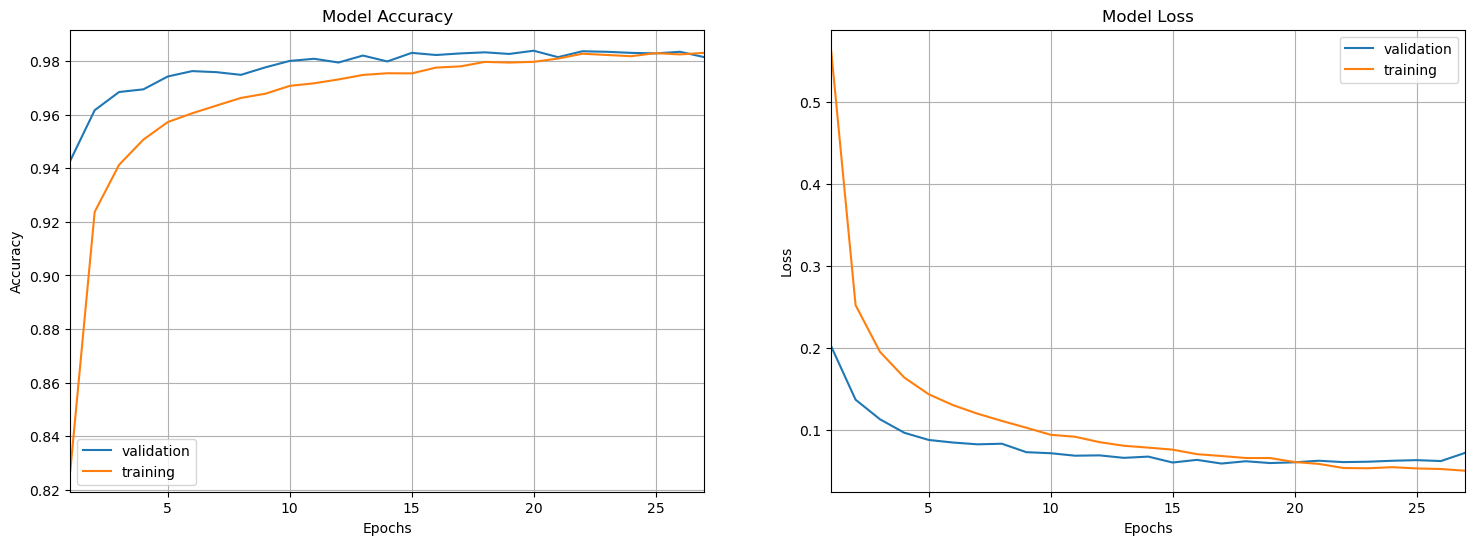

CPU times: user 15min 18s, sys: 19min 7s, total: 34min 26s
Wall time: 2min 9s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
# Dropout applied Hidden layer 1
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
# Dropout applied Hidden layer 2
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment # 8

**Summary**

This experiment keeps the **ReLU MLP** from earlier runs (Flatten, Dense **300**, Dense **100**,  **Softmax-10**) with **`random_normal`** initialization and **asymmetric Dropout** (**0.5** after the first hidden layer, **0.1** after the second), but deliberately **cranks up the SGD learning rate to 0.5**. The goal is to stress-test optimization: compared with lr = 0.1, a higher step size can speed learning but also risks **instability or oscillation**—especially with ReLU activations. Early stopping on validation loss is used as a safeguard to halt training and **restore the best weights** if the model begins to overfit or diverge.

After training on 28×28 images with integer labels (**Sparse Categorical Cross-Entropy**), the notebook reports **train/test accuracy**, prints a **confusion matrix** and **classification report** (precision/recall/F1 per class), and plots **training vs. validation accuracy and loss** across epochs. Reading these outputs together shows whether the aggressive **lr = 0.5** achieves faster convergence without sacrificing generalization or whether it overshoots, in which case the curves (and class-level errors) will reveal the trade-offs versus Experiments 6–7.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 2

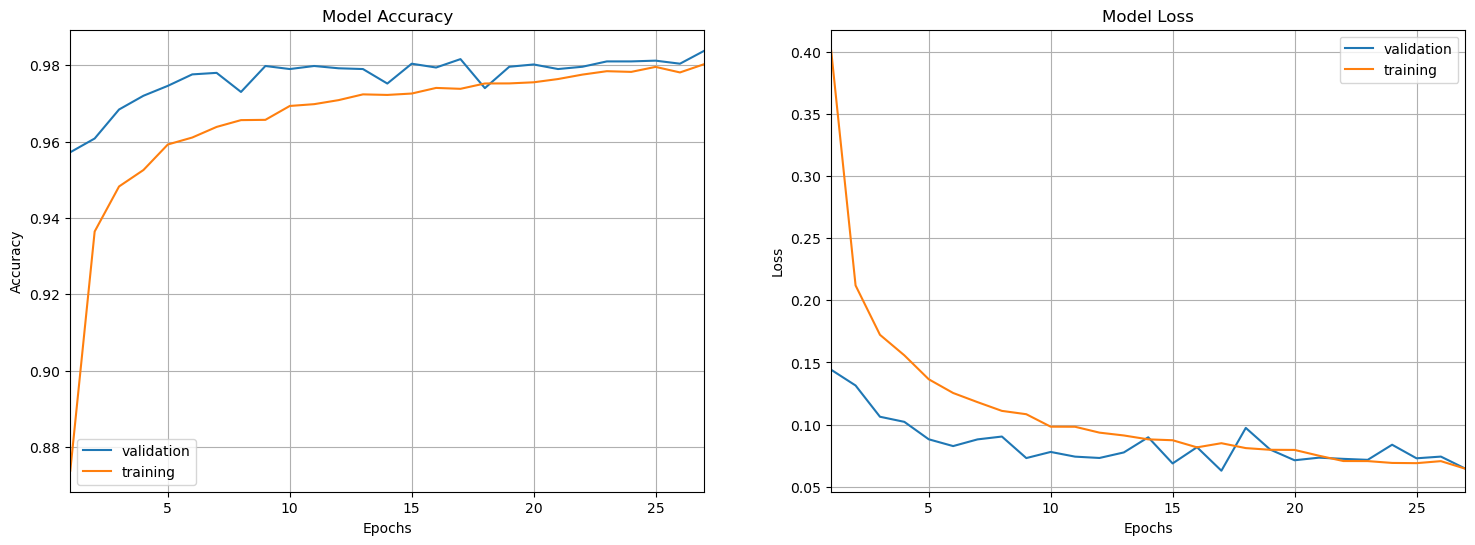

CPU times: user 8min 1s, sys: 15min 52s, total: 23min 53s
Wall time: 1min 30s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(units=300, kernel_initializer=kernel_initializer, activation=activation_hidden,
                             bias_initializer="zeros"))
# Dropout applied Hidden layer 1
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                            bias_initializer="zeros"))
# Dropout applied Hidden layer 2
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                             activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment # 9

**Summary**

This experiment scales up the MLP to a deep architecture for 10 class image classification on 28×28 inputs. After flattening the image, the model stacks ten hidden layers with 100 units each, all using ReLU activations and the random_normal initializer, followed by a softmax output with 10 probabilities. Training uses SGD with learning rate 0.1 and Sparse Categorical Cross Entropy, with early stopping on validation loss to restore the best weights.

The goal is to observe how depth and capacity influence learning dynamics, stability, and generalization when no explicit regularization like dropout is used. After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class), and visualizes accuracy and loss curves for training and validation to reveal signals of underfitting across epochs.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100) 

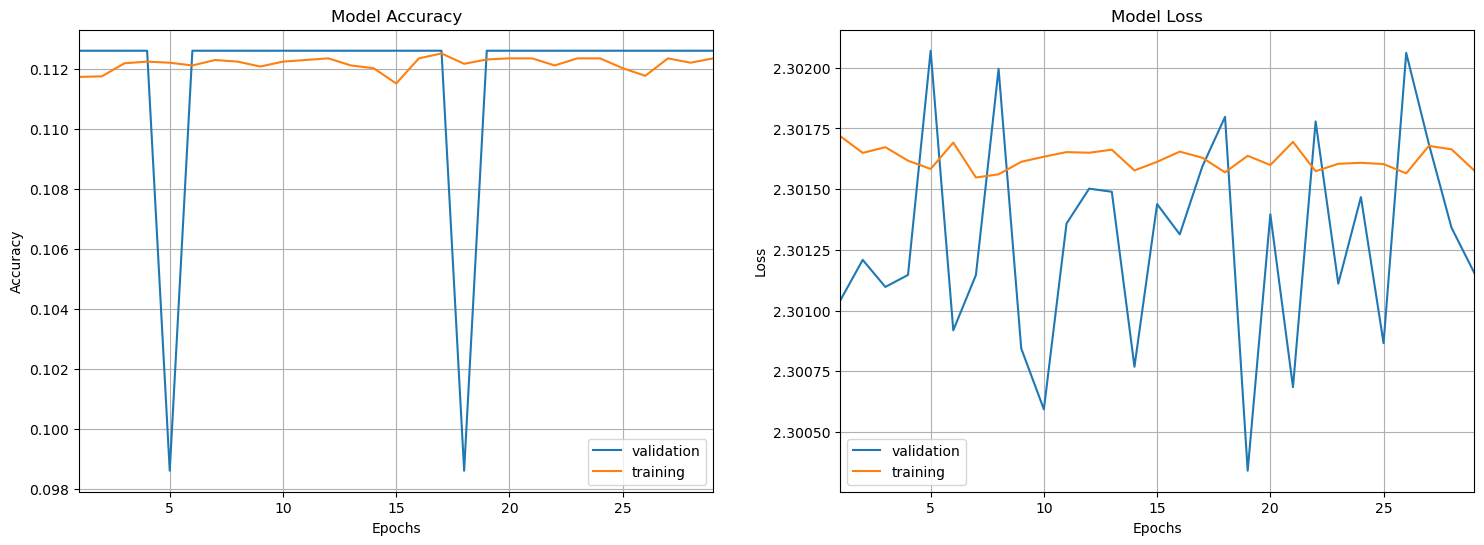

CPU times: user 9min 57s, sys: 15min 3s, total: 25min 1s
Wall time: 1min 34s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# Adding 10 hidden layers with 100 units each
for i in range(10):
    model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                                    bias_initializer="zeros"))
    # Apply Dropout with rate=0.1 to each hidden layer
    #model.add(tf.keras.layers.Dropout(rate=0.1))

# Output layer
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                                activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment # 10

**Summary**

This experiment significantly increases the model depth to study the effect of very deep fully connected architectures on 10 class image classification using 28×28 inputs. The network flattens the image and passes it through twenty hidden layers, each with 100 ReLU activated neurons initialized with random_normal weights, followed by a softmax output layer. The model uses SGD with a learning rate of 0.1 and Sparse Categorical Cross Entropy for optimization, with early stopping monitoring the validation loss to restore the best weights.

By stacking many layers, the experiment investigates how network depth influences convergence behavior, computational time, and overfitting. Deep MLPs can, in theory, capture more complex representations but are often harder to train due to vanishing gradients or optimization instability. After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class), and plots learning curves of accuracy and loss for both training and validation datasets. The results reveal whether increasing depth without additional regularization or architectural modifications enhances or hinders model performance.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100) 

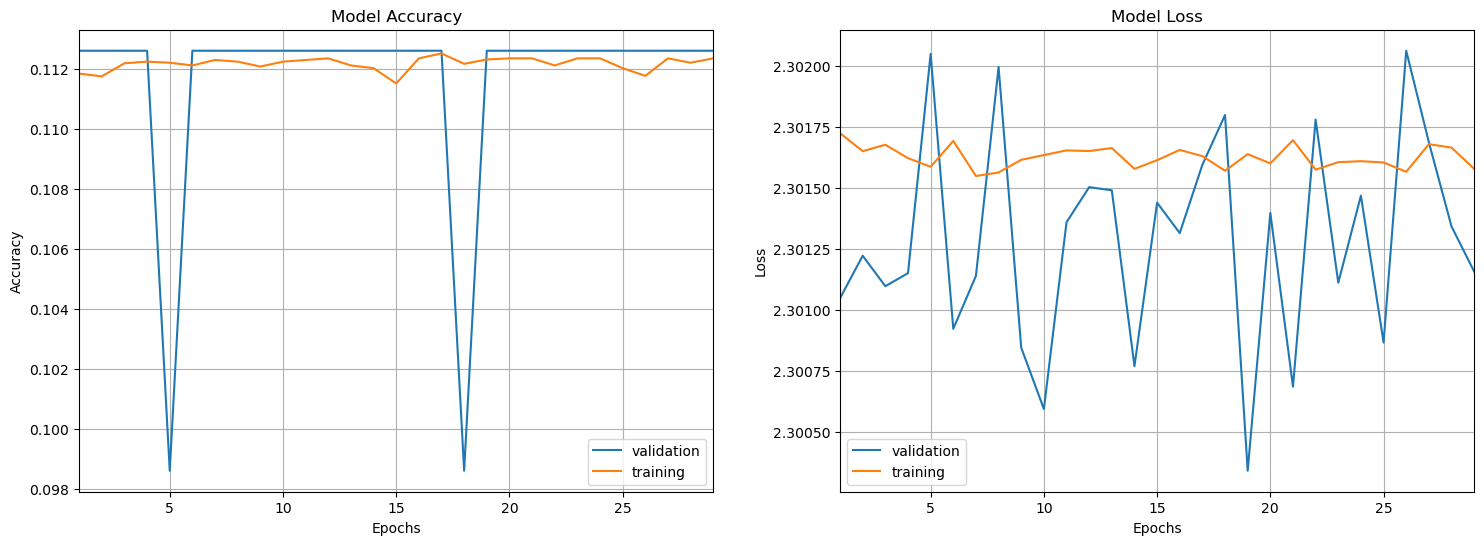

CPU times: user 12min 32s, sys: 20min, total: 32min 33s
Wall time: 2min 3s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# Adding 20 hidden layers with 100 units each
for i in range(20):
    model.add(tf.keras.layers.Dense(units=100, kernel_initializer=kernel_initializer, activation=activation_hidden,
                                    bias_initializer="zeros"))

# Output layer
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                                activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment # 11

**Summary**

This experiment develops a moderately deep multilayer perceptron (MLP) for 10 class image classification using TensorFlow and Keras, aiming to balance model complexity and generalization. The network begins by flattening the 28×28 pixel inputs, then passes them through four dense hidden layers with varying widths (100 to 300 to 300 to 100), each followed by a 10% Dropout layer to reduce overfitting by randomly deactivating neurons during training. All hidden layers use ReLU activation and random_normal initialization, while the output layer uses softmax to produce class probabilities.

The model is trained using stochastic gradient descent (SGD) with a learning rate of 0.1 and Sparse Categorical Cross Entropy loss, with early stopping monitoring validation loss to restore the best weights. The training runs for up to 30 epochs with a mini batch size of 64.

After training, the evaluation of the model’s performance on both the training and test datasets was done, and also for **confusion matrix**, **classification report** (precision/recall/F1 by class). Accuracy and loss curves for both training and validation sets are plotted to visualize convergence and generalization. This experiment explores how a carefully structured MLP with Dropout and balanced layer sizes can achieve stability, prevent overfitting, and maintain strong performance compared with both shallower and much deeper architectures tested in previous experiments.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               30300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300) 

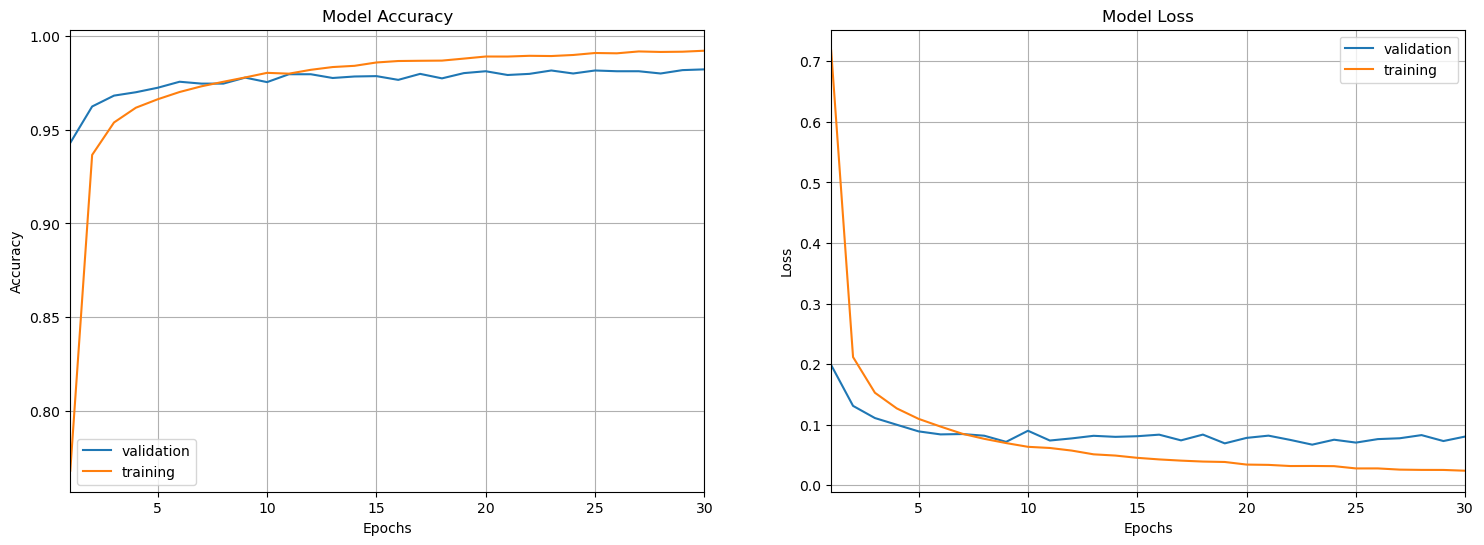

CPU times: user 9min 42s, sys: 15min 50s, total: 25min 32s
Wall time: 1min 36s


In [ ]:
%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# Hidden layers with dropout
model.add(tf.keras.layers.Dense(100, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(100, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.1))

# Output layer
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                                activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 30
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()

# Experiment #11 New Trial - Solving Overfitting


I lowered the dropout rate to 0.15 to pull validation accuracy closer to training.
I also reduced the learning rate to 0.05 to encourage slower, more stable learning for better generalization, and the overfitting was effectively addressed.


Model: "MLP_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               30300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300) 

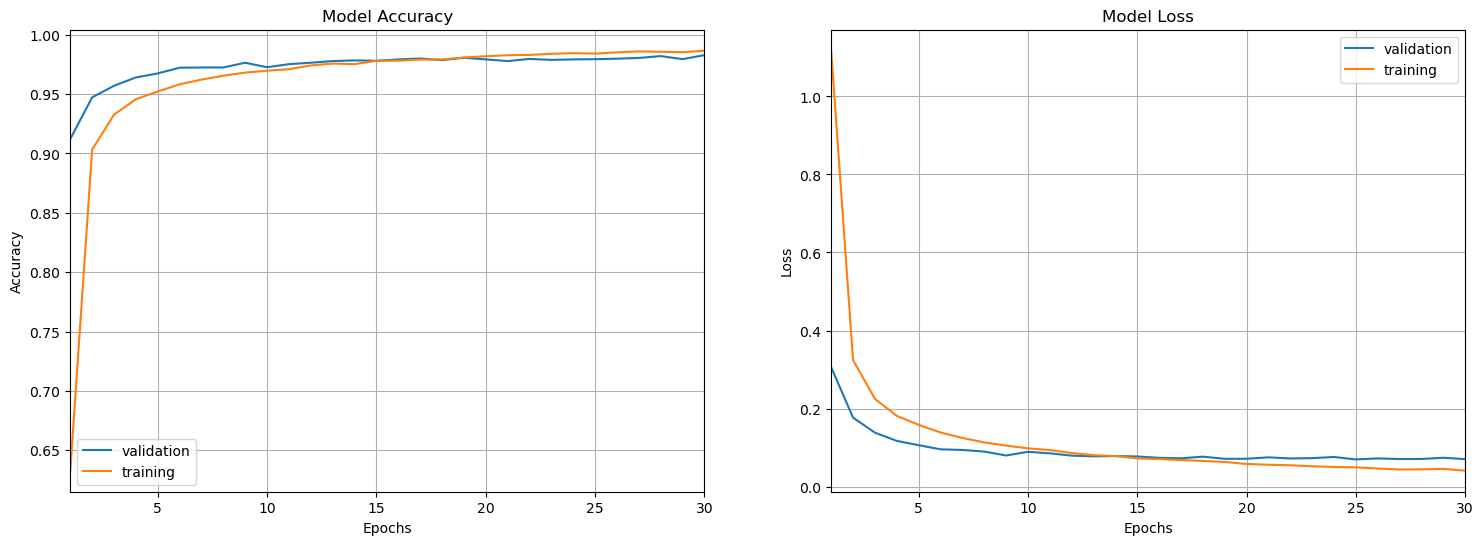

CPU times: user 6min 7s, sys: 12min 50s, total: 18min 58s
Wall time: 1min 11s


In [ ]:

%%time


'''
Delete the TensorFlow graph
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration
'''
np.random.seed(100)
tf.random.set_seed(100)

'''
Set the values for the weight initializer and activation function
'''
kernel_initializer = 'random_normal'
activation_hidden = 'relu'

# Final classification layer has 10 neurons and "softmax" activation function
activation_final = 'softmax'
number_of_classes = 10


'''
Create a Sequential model composed of a single stack of layers connected sequentially.
- Add the layers one by one.
- Apply Dropout regularization
'''
model = tf.keras.models.Sequential(name="MLP_Multiclass_Classifier")
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# Hidden layers with dropout
model.add(tf.keras.layers.Dense(100, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.15))
model.add(tf.keras.layers.Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.15))
model.add(tf.keras.layers.Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.15))
model.add(tf.keras.layers.Dense(100, kernel_initializer="random_normal", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.15))

# Output layer
model.add(tf.keras.layers.Dense(units=number_of_classes, kernel_initializer=kernel_initializer,
                                activation=activation_final))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary()

'''
Define the optimizer

'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)


'''
Define loss function
Since our labels are integer-encoded, we use SparseCategoricalCrossentropy.
'''
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Declare and initialize the early stopping callback function
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  restore_best_weights=True)

'''
Set the epochs and batch size
'''
no_of_epochs = 30
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                   )

print("Training Parameters: ", history.params)
print("\nList of Epochs: ", history.epoch)
print("\nEvaluation Metrics: ", history.history.keys())

numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()